### Partie I

In [1]:
from imutils import paths
import numpy as np
import imutils
import cv2
import os

In [2]:
def face_detection(image):
  cascadePath = "haarcascade_frontalface_default.xml"
  detector = cv2.CascadeClassifier(cascadePath)

  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  rects = detector.detectMultiScale(gray, scaleFactor=1.05,
	minNeighbors=10, minSize=(30, 30),
	flags=cv2.CASCADE_SCALE_IMAGE)

  return rects

In [3]:
def load_face_dataset(inputPath, minSamples = 15):
  # get all the image paths in the dataset folder structure and grab 
  # the name(i.e. groundtruth) of all the images and count each of them
  # and then put all of the groundtruths into a list
  imagePaths = list(paths.list_images(inputPath))
  names = [p.split(os.path.sep)[-2] for p in imagePaths]
  (names , counts) = np.unique(names , return_counts = True)
  names = names.tolist()

  faces = []
  labels = []

  # loop over all of the image paths
  for imagePath in imagePaths:
    # read the image and grab the image label
    image = cv2.imread(imagePath)
    name = imagePath.split(os.path.sep)[-2]

    # check whether the count of this specific label is
    # below our minSamples threshold or not
    if counts[names.index(name)] < minSamples:
      continue
    
    # perform face detection
    boxes = face_detection(image)
    
    # loop over the bounding boxes
    for (x , y , w , h) in boxes:
      try:
        # extract the face ROI, resize it and convert
        # it into grayscale format
        faceROI = image[y:y+h , x:x+w]
        faceROI = cv2.resize(faceROI , (47 , 62))
        faceROI = cv2.cvtColor(faceROI , cv2.COLOR_BGR2GRAY)

        # update the faces and labels list
        faces.append(faceROI)
        labels.append(name)
      except:
        continue
  # convert the faces and labels lists into Numpy array
  faces = np.array(faces)
  labels = np.array(labels)

  return (faces , labels)

In [4]:
def load_faceLBP_dataset(inputPath, minSamples = 15):
    # get all the image paths in the dataset folder structure and grab 
    # the name(i.e. groundtruth) of all the images and count each of them
    # and then put all of the groundtruths into a list
    imagePaths = list(paths.list_images(inputPath))
    names = [p.split(os.path.sep)[-2] for p in imagePaths]
    (names , counts) = np.unique(names , return_counts = True)
    names = names.tolist()

    facesLBP = []
    labels = []

    # loop over all of the image paths
    for imagePath in imagePaths:
        # read the image and grab the image label
        image = cv2.imread(imagePath)
        name = imagePath.split(os.path.sep)[-2]

        # check whether the count of this specific label is
        # below our minSamples threshold or not
        if counts[names.index(name)] < minSamples:
          continue

        # perform face detection
        boxes = face_detection(image)

        # loop over the bounding boxes
        for (x , y , w , h) in boxes:
          try:
            # extract the face ROI, resize it and convert
            # it into grayscale format
            faceROI = image[y:y+h , x:x+w]
            faceROI = cv2.resize(faceROI , (47 , 62))
            faceROI = cv2.cvtColor(faceROI , cv2.COLOR_BGR2GRAY)

            # update the faces and labels list
            facesLBP.append(faceROI)
            labels.append(name)
          except:
            continue
        # convert the faces and labels lists into Numpy array
        facesLBP = np.array(facesLBP)
        labels = np.array(labels)

    return (facesLBP , labels)

### Partie II

In [5]:
import import_ipynb
import matplotlib.pyplot as plt
from skimage import feature
import numpy as np
import cv2
import os

In [6]:
class LocalBinaryPatterns:
  def __init__(self , numPoints , radius):
    self.numPoints = numPoints
    self.radius = radius

  def describe(self , image , eps=1e-7):
    lbp = feature.local_binary_pattern(image , self.numPoints , self.radius)
    hist = plt.hist(lbp.ravel())
    return lbp , hist

In [7]:
desc = LocalBinaryPatterns(16, 5)

def preprocess_img(imagePath):
  img = cv2.imread(imagePath)
  rects = face_detection(img)
  for (x , y , w , h) in rects:
    face = img[y:y+h , x:x+w]

  face = cv2.cvtColor(face, cv2.COLOR_BGR2GRAY)
  # plt.imshow(face , cmap="gray")
  # print(face.shape)
  # face = np.array(face)
  
  lbp , hist = desc.describe(face)
  return lbp , hist

In [8]:
imagePath = "Dataset - Equipe Maroc/Aguerd/aguerd_1.jpg"

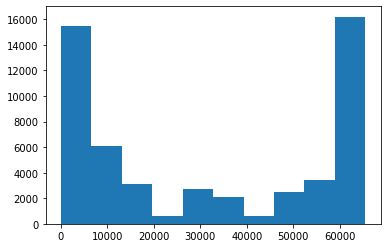

In [9]:
lbp , hist = preprocess_img(imagePath)

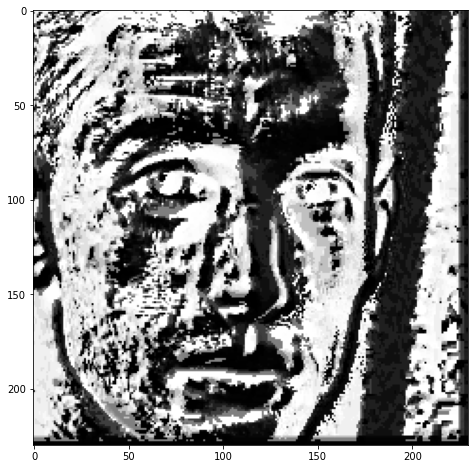

In [10]:
plt.figure(figsize=(8,8))
plt.imshow(lbp , cmap="gray")

### Partie III

In [11]:
import import_ipynb
#from face import load_face_dataset

from sklearn.metrics import f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np
import math
import imutils
import time
import cv2
import os

In [12]:
def cross_validation(input_data , cv = 5 , test_size = 0.20 , output = True , save_model=False):

  # initialize the f1-scores list
  f1_scores = []
  # grab some random numbers between 0 and 100
  random_states = np.random.randint(low = 0, high = 100 , size = cv , dtype = int)

  # extract faces and label from dataset
  (faces , labels) = load_face_dataset(input_data , minSamples=15)

  # encode the labels
  le = LabelEncoder()
  labels = le.fit_transform(labels)

  # do the training process based on the number of 
  # random_states
  for random_state in random_states:
    # split the data into training and test set
    X_train , X_test , y_train , y_test = train_test_split(faces , labels , test_size = test_size,
                                                          stratify = labels , random_state = random_state)
    
    # define and train the LBP model
    recognizer = cv2.face.LBPHFaceRecognizer_create(
        radius = 2 , neighbors = 16 , grid_x = 9 , grid_y  = 9)

    recognizer.train(X_train , y_train)

    # initialize our predictions and confidence lists
    predictions = []
    confidence = []

    # loop over the test data
    for i in range(0 , len(X_test)):
      # classify the face and update the predictions
      # and confidence scores
      (prediction , conf) = recognizer.predict(X_test[i])
      predictions.append(prediction)
      confidence.append(confidence)

    # collect and append the calculated f1-score based on this
    # random state
    f1_scores.append(f1_score(y_test,predictions,average="macro"))

  # convert the f1-scores list into Numpy array
  f1_scores = np.array(f1_scores , dtype="float32")

  if output:
    # generate a sample of testing data
    idxs = np.random.choice(range(0 , len(X_test)) , size = 10 , replace = True)

    for i in idxs:
      # grab the actual and predicted name
      predName = le.inverse_transform([predictions[i]])[0]
      actualName = le.classes_[y_test[i]]

      # grab the face image, convert back it from 1 channel
      # into 3 channels and then resize it
      face = np.dstack([X_test[i]] * 3)
      face = imutils.resize(face , width = 250)

      # draw the actual and predicted name on the image
      cv2.putText(face , "actual : {}".format(actualName) , (5 , 25),
                  cv2.FONT_HERSHEY_SIMPLEX , 0.8 , (0 , 0 , 255) , 2)
      cv2.putText(face , "prediction : {}".format(predName) , (5 , 60),
                  cv2.FONT_HERSHEY_SIMPLEX , 0.8 , (0 , 255 , 0) , 2)
      
      # display the result image and the save it into
      # the desired directory 
      plt.imshow(face , cmap="gray")
      plt.savefig("face-{}.png".format(i))
    # save the model 
  
  if save_model:
    # save the model 
    recognizer.save("face-recognizer-model.yml")

  return f1_scores

In [13]:
recognizer = cv2.face.LBPHFaceRecognizer_create(
        radius = 2 , neighbors = 16 , grid_x = 9 , grid_y  = 9)


In [ ]:
f1_scores = cross_validation("Dataset - Equipe Maroc" , cv=5 , save_model=True)

In [16]:
# grab the mean of f1-scores
mu = np.mean(f1_scores)
# grab the standard deviation of f1-scores
sigma = np.std(f1_scores)

print("The mean of f1-scores is : " , mu)
print("The standard deviation of f1-scores is : " , sigma)

The mean of f1-scores is :  0.91055554
The standard deviation of f1-scores is :  0.11769914


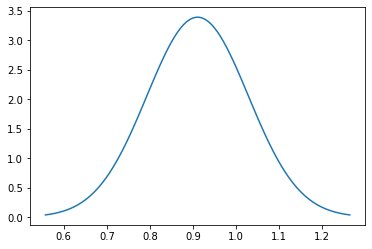

In [17]:
# calculate and divide the normal dist. range into 100 points
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
# plot the normal dist. based on the probability distribution function 
# values 
plt.plot(x, stats.norm.pdf(x, mu, sigma))
# save the plot in the desired directory
#plt.savefig("output/model-performance/f-scores-dist.png")
plt.show()